# Titanic Survival Prediction: 01 - Data Cleaning and Feature Engineering
*Date: TODO*
*Author: Jonas Lilletvedt*

--- 

## 1. Introduction and Setup

### 1.1. Objective

In this notebook we will focus on data cleaning and feature engineering. Building on the findings from our initial exploration in `00_initial_data_exploration.ipynb`, this notebook's primary objective is to construct a robust end-to-end pre-processing pipeline. This pipeline will transform raw data into clean, feature-rich dataset ready for modeling, while ensuring results are reproducible and free from data leakage.

To achieve this, our pipeline will systematically perform these tasks:
1.  **Data Cleaning and Imputation:**
    *   Address missing data in `Age`, `Embarked`.
    *   Normalize the positive skewed data in `Fare`.
2.  **Advanced Feature Engineering:**
    *   Extract `Title` from `Name` column to act as a proxy for age, sex, marriage- and social-status.
    *   Use `Surname` from `Name` and `Pclass` to identify families, and engineer a new feature `FamilySurvivalRate` representing the mean survival rate for that family, excluding the passenger themselves.
    *   Create a binned `FamilySize` feature from `SibSp` and `Parch`.
    *   Derive `Deck` (vertical location) and `Zone` (horizontal location) from `Cabin`.
    *   Bin the `Age` feature to better represent the non-linear relationship to `Survived`.

The entire process will be wrapped in a `scikit-learn` `Pipeline`, implemented using a set of custom transformers for our distinct logic, and a `ColumnTransformer` for standard pre-processing tasks.

### 1.2 Recap of Findings from Exploratory Data Analysis

The preceding data analysis (`00_initial_data_exploration.ipynb`) revealed several key insights and quality issues that will determine our work here:

**Key Predictive Relationships:**
*   **Dominant Predictors:** `Sex` and `Pclass` were found to be the strongest predictor for survival.
    *   Females had a vastly higher survival rate (~74%) then males (~18%).
    *   There was a clear linear relationship between passenger class and survival rate. First class passengers had a survival rate of ~63% compared to second and first class passengers ~63% and ~24% respectively.

**Data Quality and Structural Issues:**
*   **Missing Data:** Multiple columns were missing significant amounts of data.
    *   `Cabin`(~77% missing)
    *   `Age` (~20% missing)
    *   `Embarked` (2 missing values)
*   **Outliers and Skewness:** The `Fare` column show a substantial discrepancy in the 75% quantile (31$) and max value (512$).
*   **Features Requiring Transformation:** The columns `Name`, `Ticket` and `Cabin` are not suitable for direct use but contain valuable information that can be extracted:
    *   `Name` can be deconstructed to extract `Title` (a proxy for sex, age, marriage- and social-status) and `Surname` for family identification. 
    *   From `Cabin` we can gather positional information for `Deck` (vertical location) and `Zone` (horizontal location).
    *   `SibSp` and `Parch`can be combined for a more powerful feature, `FamilySize`.

## 2. Data Loading and Setup

---

The first step in this notebook is to load in the correct libraries followed by the train and test datasets.

All modifications will be applied to both the `train` and `test` sets for consistency. To prevent data leakage and ensure our model's performance is realistically evaluated, all transformations parameters -- such as values for imputation or scaling factors -- will be extracted solely from the `train` dataset. The test must and will only be used for model evaluation, and not influence any part of the data analysis or pre-processing steps.

### 2.1. Library Imports

In [110]:
# Import necessary libraries

# Data manipulation and analysis
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn tools for preprocessing and modeling
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin

### 2.2. Load Datasets

In [111]:
# Load datasets
df_train = pd.read_csv('../data/01_raw/train.csv')
df_test = pd.read_csv('../data/01_raw/test.csv')

### 2.3. Initial Inspection 

A quick inspection to check the dataset are loaded properly and expected. 

**Dataset Shapes:**

In [112]:
# Check shape of each dataset
print(f'Training data shape: {df_train.shape}')
print(f'Test data shape: {df_test.shape}')

Training data shape: (891, 12)
Test data shape: (418, 11)


**Data Preview:**

In [113]:
# Check five first rows of `df_train`
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [114]:
# Check five first rows of `df_test`
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


**Data Types and Missing Values:**

In [115]:
# Types and missing values for `df_train`
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [116]:
# Types and missing values for `df_test`
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


Unlike our train set we also have missing values in `Fare` in addition to `Cabin` and `Age`. 

Now that we have gotten a feel for the data, and checked everything is working as expected we will move on to `Data Cleaning and Imputation`.

### 2.4. Initial Findings and Plan Adjustments

The inspection confirms the missing values in `Age`, `Cabin` and `Embarked` in the training set, as we expected from the EDA.

Alongside the previous findings we have also discovered missing values in the test set, this include `Age` and `Cabin` similar to the train set. In addition we the test set have one missing value in `Fare`. Thus, our pipeline must be able to handle `Fare` imputation along the previous transformers.

## 3. Exploratory Feature Engineering and Validation

--- 

Feature selection is an important step before pipeline development. We will therefore perform an exploratory analysis to evaluate the value of the proposed engineered features.

Thus, this section will act as an 'scratchpad' for our feature engineering ideas. 

### 3.1. Evaluating the `Title` feature

We will begin our feature engineering exploration with `Title`. As hypothesized in the introduction, a passenger's title has the potential to be a strong proxy for age, and survival. 

It is crucial to evaluate `Title` first, because our `Age` imputation strategy will depend on it. We will analyze `Title`'s relationship with both variables accordingly.

In [117]:
# Make copy for scratchpad
df_scratch = df_train.copy()

# Add new columns
df_scratch['Surname_feat'] = df_scratch['Name'].str.extract(pat=r'^(.+?),', expand=False)
df_scratch['Title_feat'] = df_scratch['Name'].str.extract(pat=' ([A-Za-z]+\.)', expand=False)

# Check it worked as expected
#Check for null values
print(f'''Missing Surnames: {df_scratch['Surname_feat'].isnull().sum()}''')
print(f'''Missing Titles: {df_scratch['Title_feat'].isnull().sum()}''')

# Check five first strings
df_scratch.head()

Missing Surnames: 0
Missing Titles: 0


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Surname_feat,Title_feat
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Braund,Mr.
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Cumings,Mrs.
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Heikkinen,Miss.
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Futrelle,Mrs.
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Allen,Mr.


In [118]:
# We will now change all *titles* with less then 10 occurrences to a new class 'Rare'
# Rare titles
rare_titles = df_scratch['Title_feat'].value_counts()[lambda x: x < 10]
# Swap to 'Rare'
df_scratch['Title_feat'] = df_scratch['Title_feat'].apply(lambda x: 'Rare' if x in rare_titles else x)

The code is working as expected, we successfully extracted `Title` and `Surname`. We can now proceed with the analysis, the first step is to examine the relationship between `Title_feat` and `Survived`.

**A Note on Naming Conventions:** *For clarity, all new features engineered will be noted with `_feat` suffix to distinguish them from the original raw variables.*

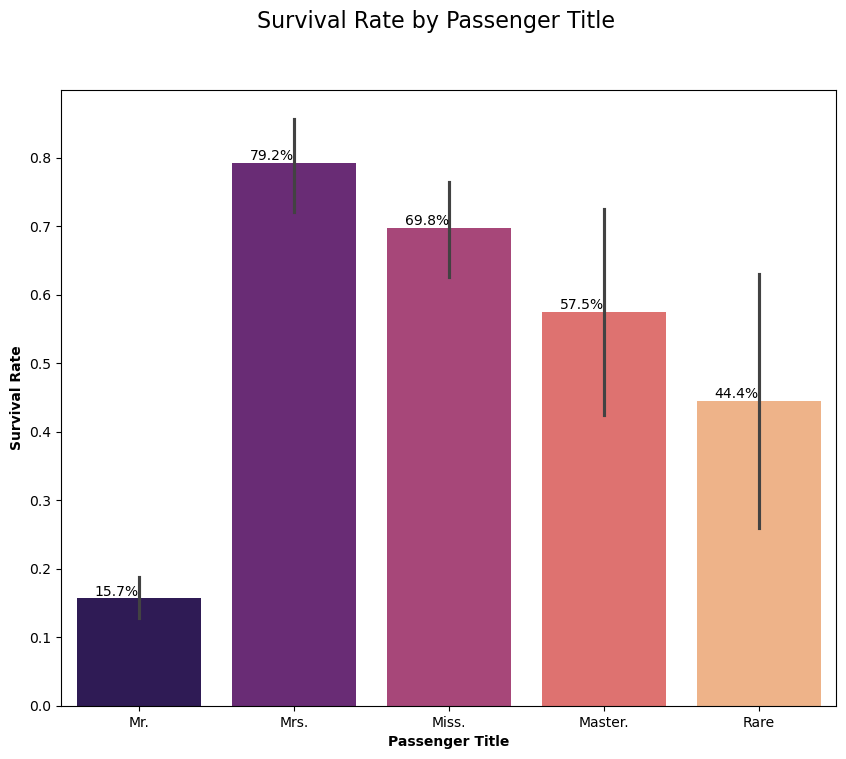

In [119]:
# Create figure
fig = plt.figure(figsize=(10, 8))

# Add plot
ax = sns.barplot(data=df_scratch, x='Title_feat', hue='Title_feat', y='Survived', palette='magma', legend=False)

# Labels
plt.suptitle('Survival Rate by Passenger Title', fontsize=16)
ax.set_ylabel('Survival Rate', fontweight='bold')
ax.set_xlabel('Passenger Title', fontweight='bold')

# Add percentage
for p in ax.patches:
    percentage = f'{p.get_height():.1%}'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(text=percentage, xy=(x,y), va='bottom', ha='right')
# Show plot
plt.show()


**Observation from `Survival Rate by Passenger Title`:** This looks very promising, each title have a distinct survival rate compared to the others.
*   **High Survival Groups:** Female-associated titles such as *Mrs.* (~79%) and *Miss.* (~70%) have a very high survival rate, this aligns with our previous findings in `00_initial_dat_exploration`. Young boys also seem to be favored in terms of survival (~58%). It is worth to note that young girls (*Miss.*) seem to be less prioritized than adult or and married women (*Mrs.*)
*   **Adult men (*Mr.*) are far below all other groups** with a survival rate of mere 15.7%.
*   **The *Rare* class** seem to be a mix of males and females, of all ages, due to their mediocre survival rate.

**Conclusion:** Passenger title is a promising predictive feature for `Survived`, and will be included for the final pipeline.

**Note for Further Iterations:** The *Rare* category could be further refined in a later iteration. Instead of grouping all uncommon titles, we could implement a more nuanced mapping, based on other features. 

For a example, a rule based system could be developed using domain knowledge:
*   A passenger with title *Dr.* could be re-categorized as an *Mr.* if male and *Mrs.* if female. This way we can make a clear distinction on sex, and can take use of the strong predictive ability of **Sex**.
*   Any male passengers with a *Rare* title would be placed in *Master.*, subsequently any young females would be placed in *Miss.*.

We will now analyze the relationship between `Title_feat` and `Age` to see if we can use `Title_feat` to make accurate imputations for `Age`.

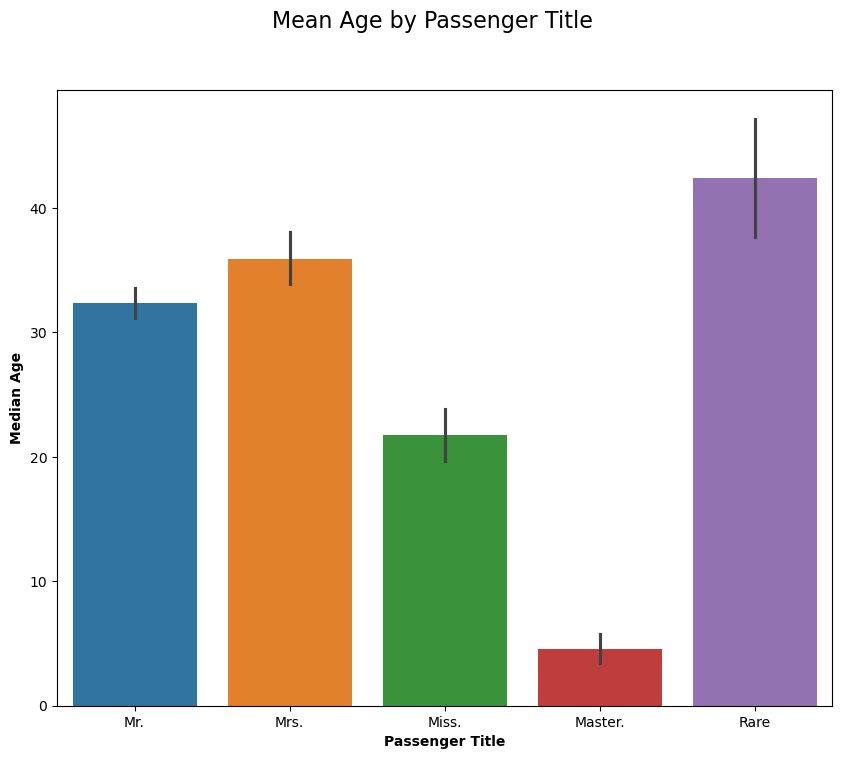

In [120]:
# Create figure
fig = plt.figure(figsize=(10,8))

# Add plot
ax = sns.barplot(data=df_scratch, x='Title_feat', y='Age', hue='Title_feat')

# Labels
ax.set_ylabel('Median Age', fontweight='bold')
ax.set_xlabel('Passenger Title', fontweight='bold')
plt.suptitle('Mean Age by Passenger Title', fontsize=16)

plt.show()

**Observations from `Mean Age by Passenger Title`:** The figure clearly show a clear association between passenger title and age. Furthermore, the variance is small across all titles. This indicates `Title_feat` as an excellent proxy for age, and is well suited for imputations. 

**Conclusion:** `Title_feat` is a great stratification variable for imputing `Age`, thus we will move forward as `Title_feat` as basis for imputation.

**A Note on the Previous Note:** `Rare` primarily looks to be a passenger title exclusively for elderly passengers, however it still might be beneficial to make a distinction between the sexes in the category.

### 3.2. Evaluating the `FamilySurvivalRate_feat` feature

We will now engineer and evaluate `FamilySurvivalRate_feat`, the new feature could have a strong predictive value, but is also inclined to cause noise and have high-variance. Each identifiable family is likely between 1-10 members in size. Small families are therefore subject to high variance, and noise.

To mitigate this issue we will explore different approaches, such as *smoothing*.

In [121]:
# Create `FamilyID` -- We will use `Surname` extracted in the previous section together with `Pclass`

# Print number of distinct surnames, the amount of unique family_id should be a tiny bit higher since it distinguishes between surnames in different passenger classes
print(f'''Count of distinct surnames: {df_scratch['Surname_feat'].nunique()}''')

# Add family_id
df_scratch['FamilyID_feat'] = df_scratch['Surname_feat'] + '_' + df_scratch['Pclass'].astype(str)

# Factorize famile_id for faster operations
df_scratch['FamilyID_feat'], unique = pd.factorize(df_scratch['FamilyID_feat'])

# Check to see if count of distinct ids are as expected
print(f'''Count of distinct family ID's: {df_scratch['FamilyID_feat'].nunique()}''')

# Check after operations
df_scratch.head()

Count of distinct surnames: 667
Count of distinct family ID's: 686


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Surname_feat,Title_feat,FamilyID_feat
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Braund,Mr.,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Cumings,Mrs.,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Heikkinen,Miss.,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Futrelle,Mrs.,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Allen,Mr.,4


A quick sanity check reveals that the number of distinct `FamilyID_feat`'s is slightly higher than the number of distinct `Surname_feat`'s. This confirms that our `FamilyID_feat` has successfully distinguished between families with the same surname but different `Pclass` values.

We will now move on to calculating and assigning family survival rate. To avoid data leakage it is crucial to not include the passenger's on survival / death in the calculation.

### 3.3. Evaluating the `AgeBinned_feat` feature

The next step is to evaluate if a binned-age feature raises the predictive value of `Age`. Since we found `Title_feat` to be a valid stratification variable and baseline for `Age` imputation, we will primarily focus on `Age` and `AgeBinned_feat` predictive value after imputation. All missing `Age` values need to be imputed and our analyze should reflect this.

Previously, we considered using both `Title_feat` and `Pclass` to impute `Age`. However, due to the discovery of `Title_feat` being a strong proxy for age this appears to be unnecessary, mainly due to the low variance. In addition these minor errors in imputation is unlikely to have an impact after binning.

In [122]:
# Impute missing values for `Age`
# Calculate median for each Passenger Title -- This value will be used for imputation
median_age_per_title = df_scratch.groupby('Title_feat')['Age'].median()

# Check median for each title
print(median_age_per_title)

# Impute missing values in `Age`
df_scratch['Age'] = df_scratch['Age'].fillna(df_scratch['Title_feat'].map(median_age_per_title))

# Pring count of missing values in `Age`
print(f'''Missing value count for Age: {df_scratch['Age'].isnull().sum()}''')

Title_feat
Master.     3.5
Miss.      21.0
Mr.        30.0
Mrs.       35.0
Rare       44.5
Name: Age, dtype: float64
Missing value count for Age: 0


Now that we have imputed the missing values in `Age` we will evaluate the predictive performance of `Age` against `AgeBinned_feat`.  

First, we need to engineer the new feature, `AgeBinned_feat`.

In [123]:
# Setting up bins
# Infant: 0-5, Child: 6-12, young-adult: 13-25, adult: 26-50, elder: 51->
bins_labels = ['Infant', 'Child', 'Young-Adult', 'Adult', 'Senior']
bins_edges = [0, 5, 12, 25, 50, np.inf]

# Add new age-binned feature
df_scratch['AgeBinned_feat'] = pd.cut(df_scratch['Age'], bins=bins_edges, labels=bins_labels, right=True, include_lowest=True)

# Check, we used tail since the first five rows only include adults
df_scratch.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Surname_feat,Title_feat,FamilyID_feat,AgeBinned_feat
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S,Montvila,Rare,683,Adult
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S,Graham,Miss.,236,Young-Adult
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,21.0,1,2,W./C. 6607,23.45,NaN,S,Johnston,Miss.,619,Young-Adult
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C,Behr,Mr.,684,Adult
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q,Dooley,Mr.,685,Adult


We will now plot `AgeBinned_feat` predictive ability against `Age`.

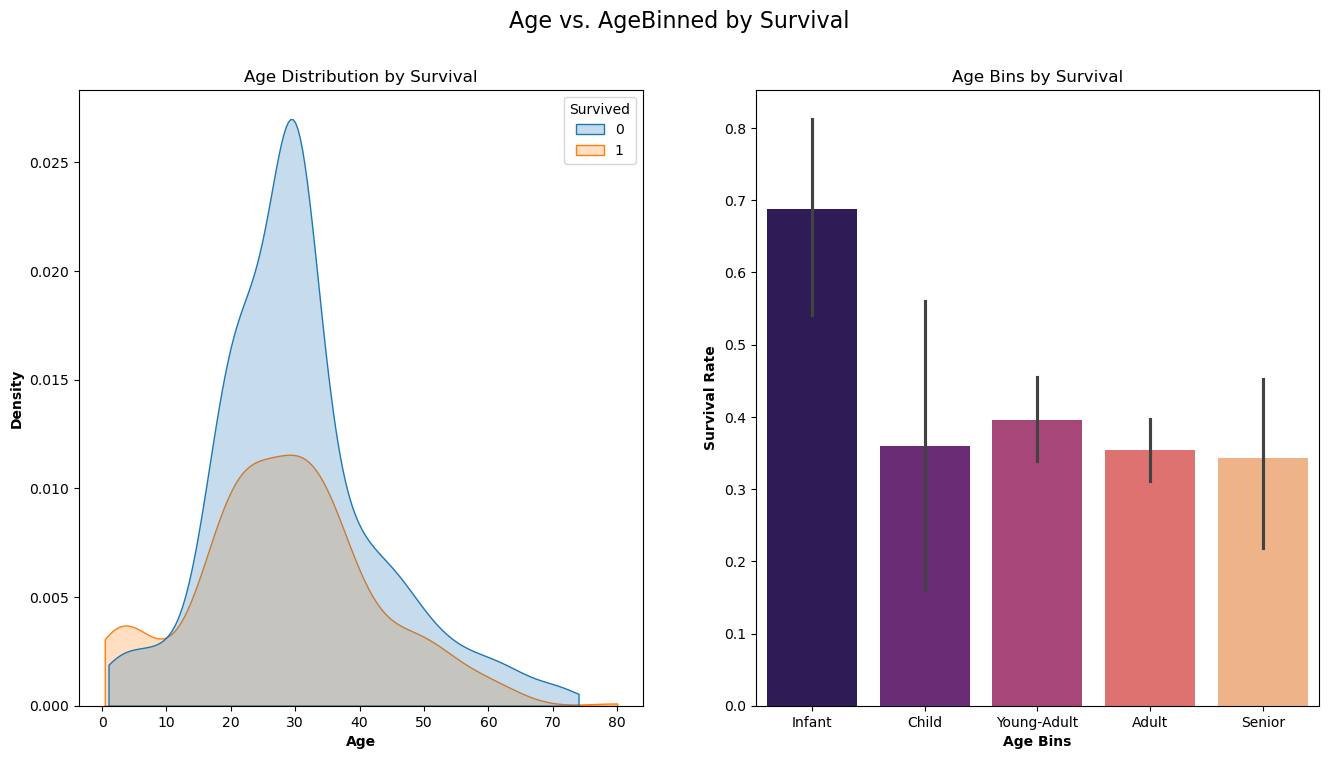

In [124]:
# Create figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Add age distribution vs. survival
sns.kdeplot(data=df_scratch, x='Age', ax=ax1, hue='Survived', cut=0, fill=True)

# Add age-binned vs. survival
sns.barplot(data=df_scratch, x='AgeBinned_feat', y='Survived', hue='AgeBinned_feat', palette='magma')

# Add labels
plt.suptitle('Age vs. AgeBinned by Survival', fontsize=16)
ax1.set_title('Age Distribution by Survival', fontsize=12)
ax2.set_title('Age Bins by Survival', fontsize=12)
ax1.set_ylabel('Density', fontweight='bold')
ax1.set_xlabel('Age', fontweight='bold')
ax2.set_ylabel('Survival Rate', fontweight='bold')
ax2.set_xlabel('Age Bins', fontweight='bold')

plt.show()

To the left, we observe `Age`'s distribution by `Survived` status. As shown in the `00_initial_data_exploration`, `Age` exhibits a clear non-linear relationship to `Survived`. 

This non-linear trend is further confirmed by the right plot, visualizing survival rate across age-bins. `AgeBinned_feat` effectively captures this non-linear relationship. 

Using `AgeBinned_feat` instead of the continuos `Age` will allow simpler models to better leverage this pattern, improving both performance and interpretability.

### 3.4. Evaluating the `FamilySize_feat`

We will noe move on to engineering and evaluating `FamilySize_feat`. It is crucial that the new feature performance better then `SibSp` and `Parch` separately to justify its inclusion.

To start `FamilySize_feat` will be a numerical feature. However we will analyze its predictive value as categorical feature to determine which representation yields the best results for our models.

In [125]:
# Creating FamilySize 


## 4. Building the Pre-processing and Modeling Pipeline

---

In this section we will construct the components for our final, end-to-end pipeline. 

**A Note on Project Structure:** In a production setting, all source code for the pipeline would typically be organized into a `src`directory for modularity, reusability and testing. However, for the sake of clarity and simplicity for the reader, we will define these components below. This allows the reader to follow each step of the logic directly.

### 3.1. Custom Transformers

## 3. Data Cleaning and Imputation

---

Our exploratory data analysis revealed several data quality issues that must be resolved before feature engineering can start:

1.  **Handle Outliers and Skewed data in `Fare`:** Apply a log-transformation to the column.
2.  **Impute `Embarked`:** Fill the two missing values using the mode.
3.  **Impute `Age`:** Impute the missing values in `Age`, using the median age grouped by `Title` and `Pclass`.

**Note on `Cabin`:** Due to the severe amount of missing data (~77%), a simple imputation is not feasible. Instead, we will treat this as a feature engineering task by extracting positional information to create two new features: `Deck` and `Zone`. For passengers with missing cabin data, these new features will be assigned an 'Unknown' class. Consequently, the handling of `Cabin` is deferred to the `Feature Engineering` section.